# Analizy eksploracyjna (EDA)

In [1]:
import sys
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from collections import Counter
from nltk.corpus import stopwords
import numpy as np
import nltk

sys.path.append(os.path.abspath("../../"))
from src.utils import load_train_test_data, get_params

In [2]:
dataset = "sephora"

In [3]:
# Parameters
dataset = "rt-polarity"


In [4]:
print(f"dataset: {dataset}")

dataset: rt-polarity


In [5]:
df, _ = load_train_test_data("data/train_test_data", dataset)
common_params, custom_params = get_params(dataset)

2025-04-14 18:02:05 - INFO - Loading train and test data


### Analiza typów danych

### Dane kategoryczne oraz numeryczne

In [6]:
cath_cols = custom_params["features"]["categorical"]
num_cols = custom_params["features"]["numerical"]
label_col = custom_params["features"]["label"]

cath_cols.append(label_col)

- **ile znajduje się w zbiorze cech kategorycznych, a ile numerycznych?**

In [7]:
print(f"Cech kategorycznych: {len(cath_cols)}")
print(f"Cech numerycznych: {len(num_cols)}")

print(f"Kategoryczne: {cath_cols}")
print(f"Numeryczne: {num_cols}")

Cech kategorycznych: 2
Cech numerycznych: 3
Kategoryczne: ['contains_bad', 'label']
Numeryczne: ['review_length', 'exclamation_count', 'unique_word_count']


- **czy zmienna wyjściowa jest kategoryczna, czy numeryczna?**

In [8]:
print(f"Zmienna wyjściowa posiada wartości: {df[label_col].unique()}")

Zmienna wyjściowa posiada wartości: [1 0]


- **czy i ile w zbiorze jest brakujących wartości? Dla jakich zmiennych? Co z tego wynika? Jakie są możliwe sposoby radzenia sobie z brakującymi wartościami?**

In [9]:
print(
    f"W zbiorze {'' if df.isnull().values.any() else 'nie'}występują brakujące wartości."
)
print(
    f"W zbiorze występuje {df[cath_cols + num_cols].isnull().sum().sum()} brakujących wartości."
)
df[cath_cols + num_cols].isnull().sum()

W zbiorze niewystępują brakujące wartości.
W zbiorze występuje 0 brakujących wartości.


contains_bad         0
label                0
review_length        0
exclamation_count    0
unique_word_count    0
dtype: int64

**- czy któreś z cech są skorelowane? Co z tego może wynikać?**

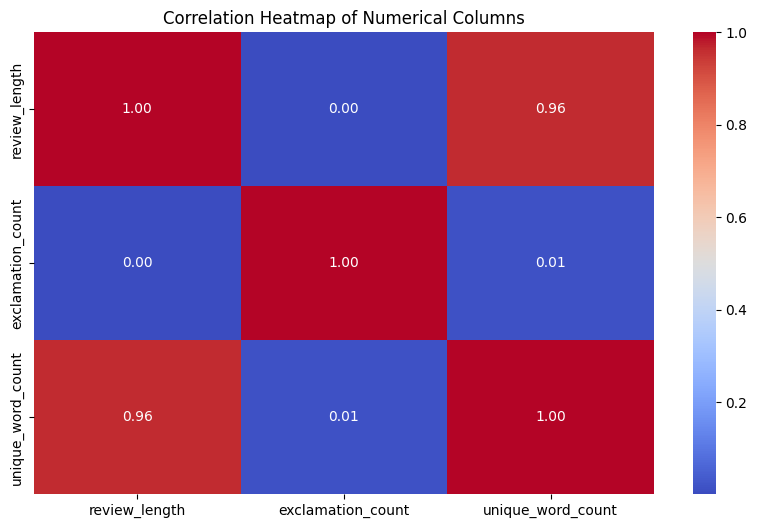

In [10]:
plt.figure(figsize=(10, 6))
sns.heatmap(df[num_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Numerical Columns")
plt.show()

**- czy któraś z cech koreluje ze zmienną wyjściową? Jeśli tak - która? Czy któraś nie koreluje?**

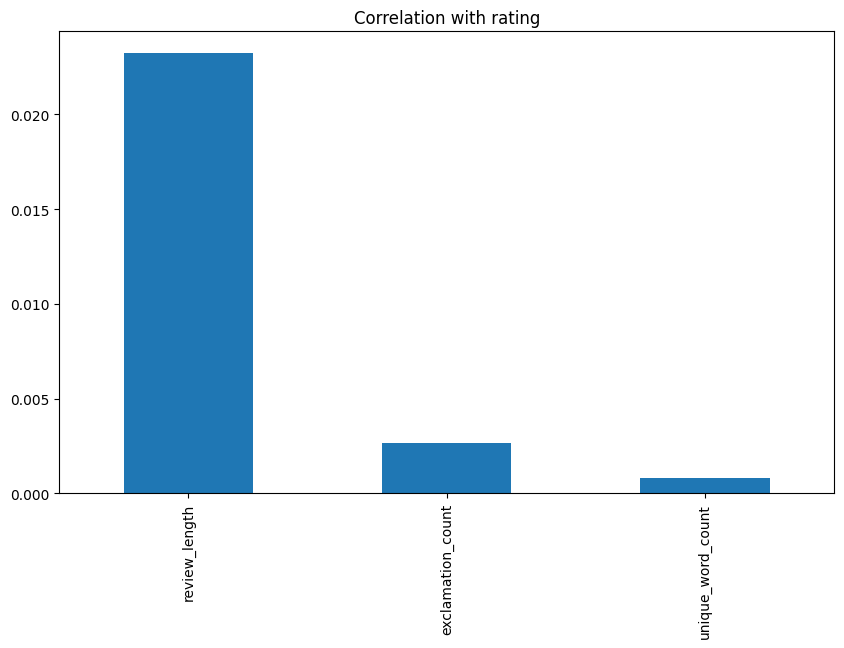

In [11]:
correlation = df[num_cols + [label_col]].corr().abs()
correlation_label = correlation[label_col].drop(label_col)

plt.figure(figsize=(10, 6))
correlation_label.sort_values(ascending=False).plot(kind="bar")
plt.title("Correlation with rating")
plt.show()

### Dane tekstowe

In [12]:
text_cols = custom_params["features"]["text"]

**- czy któreś ze słów wydają się dominować w zbiorze?**

In [13]:
def clean_text(text):
    text = re.sub(r"[^a-zA-Z\s]", "", str(text))
    text = text.lower()
    return text

In [14]:
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))
df["cleaned_text"] = df["review_text"].apply(clean_text)
df["cleaned_text_tokens"] = df["cleaned_text"].apply(
    lambda x: [word for word in x.split() if word not in stop_words]
)
all_words = [word for tokens in df["cleaned_text_tokens"] for word in tokens]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
word_counts = Counter(all_words)
word_freq_df = pd.DataFrame(word_counts.items(), columns=["word", "count"]).sort_values(
    by="count", ascending=False
)

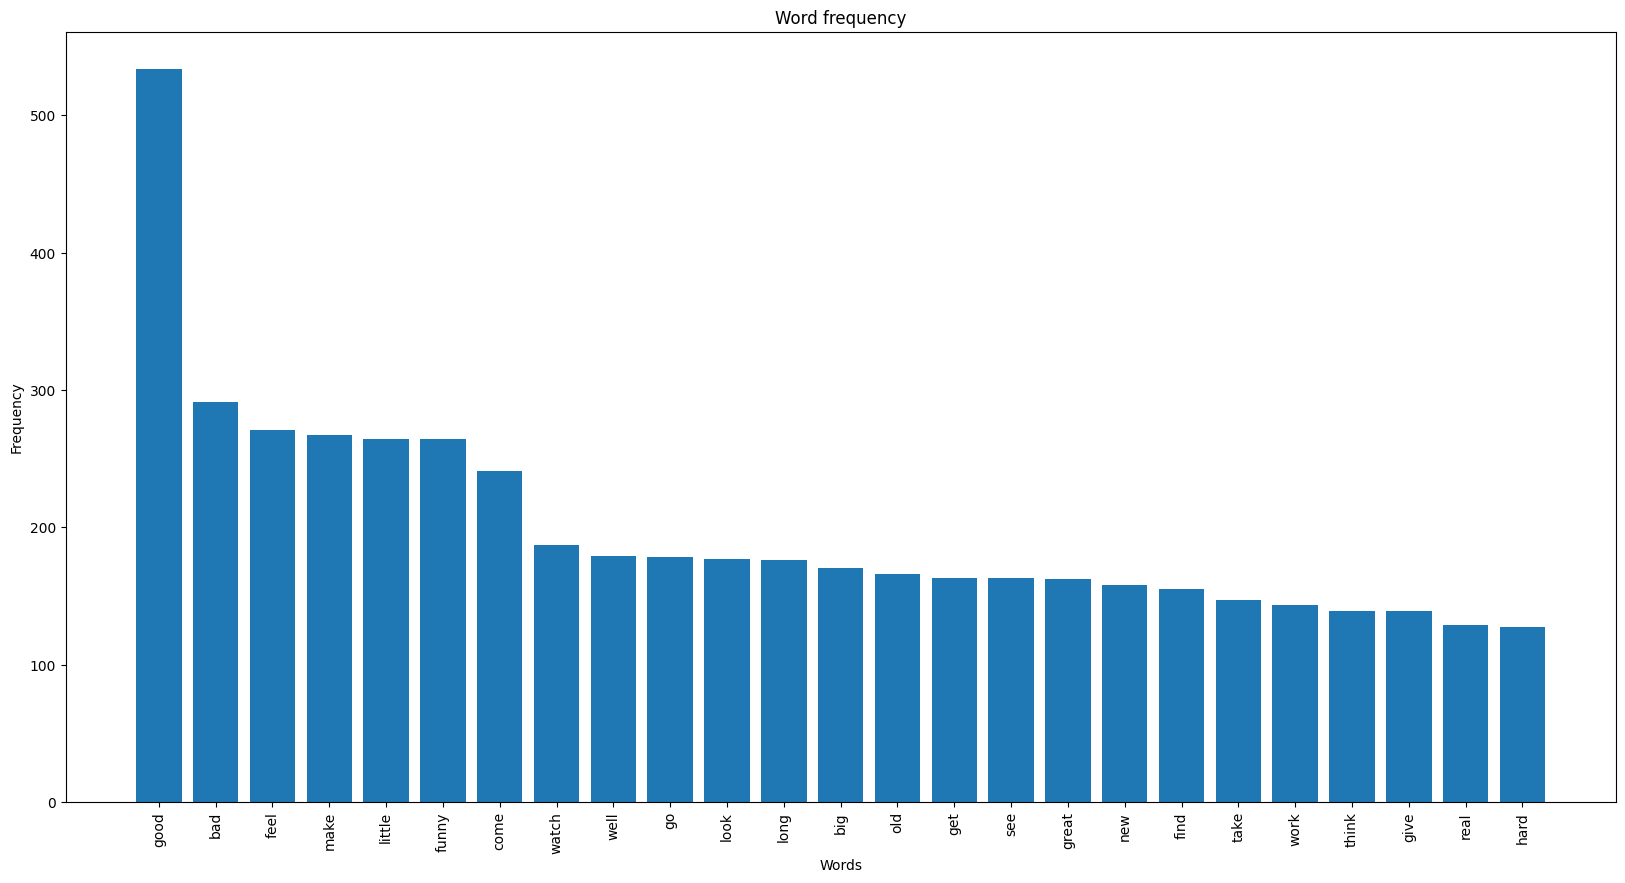

In [16]:
plt.figure(figsize=(20, 10))
plt.bar(word_freq_df["word"][0:25], word_freq_df["count"][0:25])
plt.xticks(rotation=90)
plt.title("Word frequency")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

**- czy najpopularniejsze słowa różnią się znacząco pomiędzy klasami? Czy potrafisz wyróżnić słowa mogące wpływać w znaczym stopniu na sentyment?**

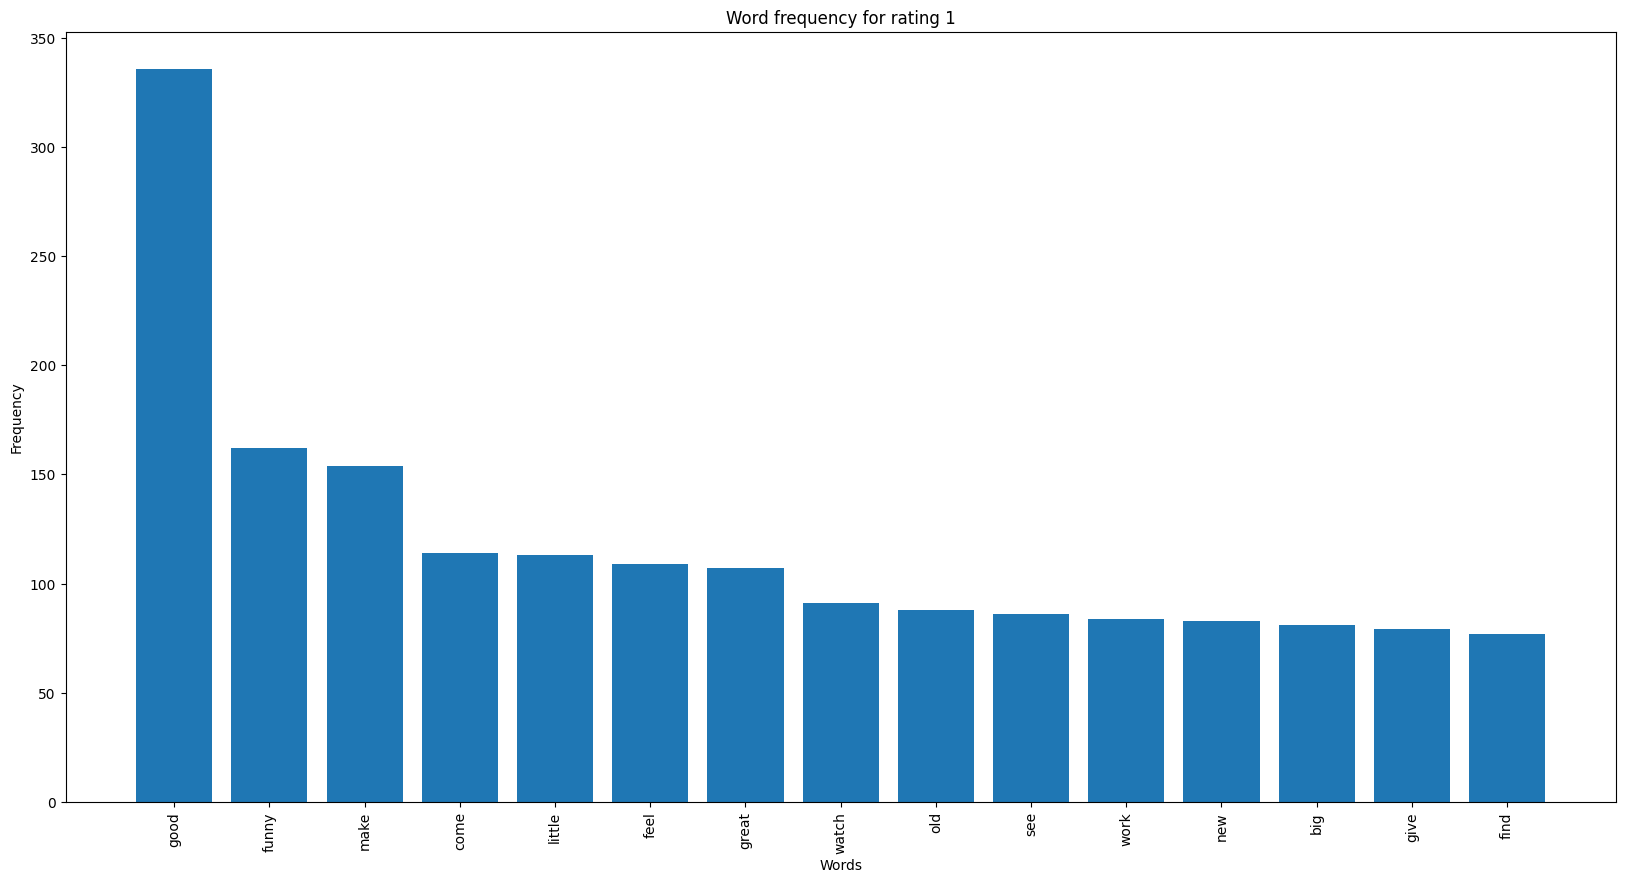

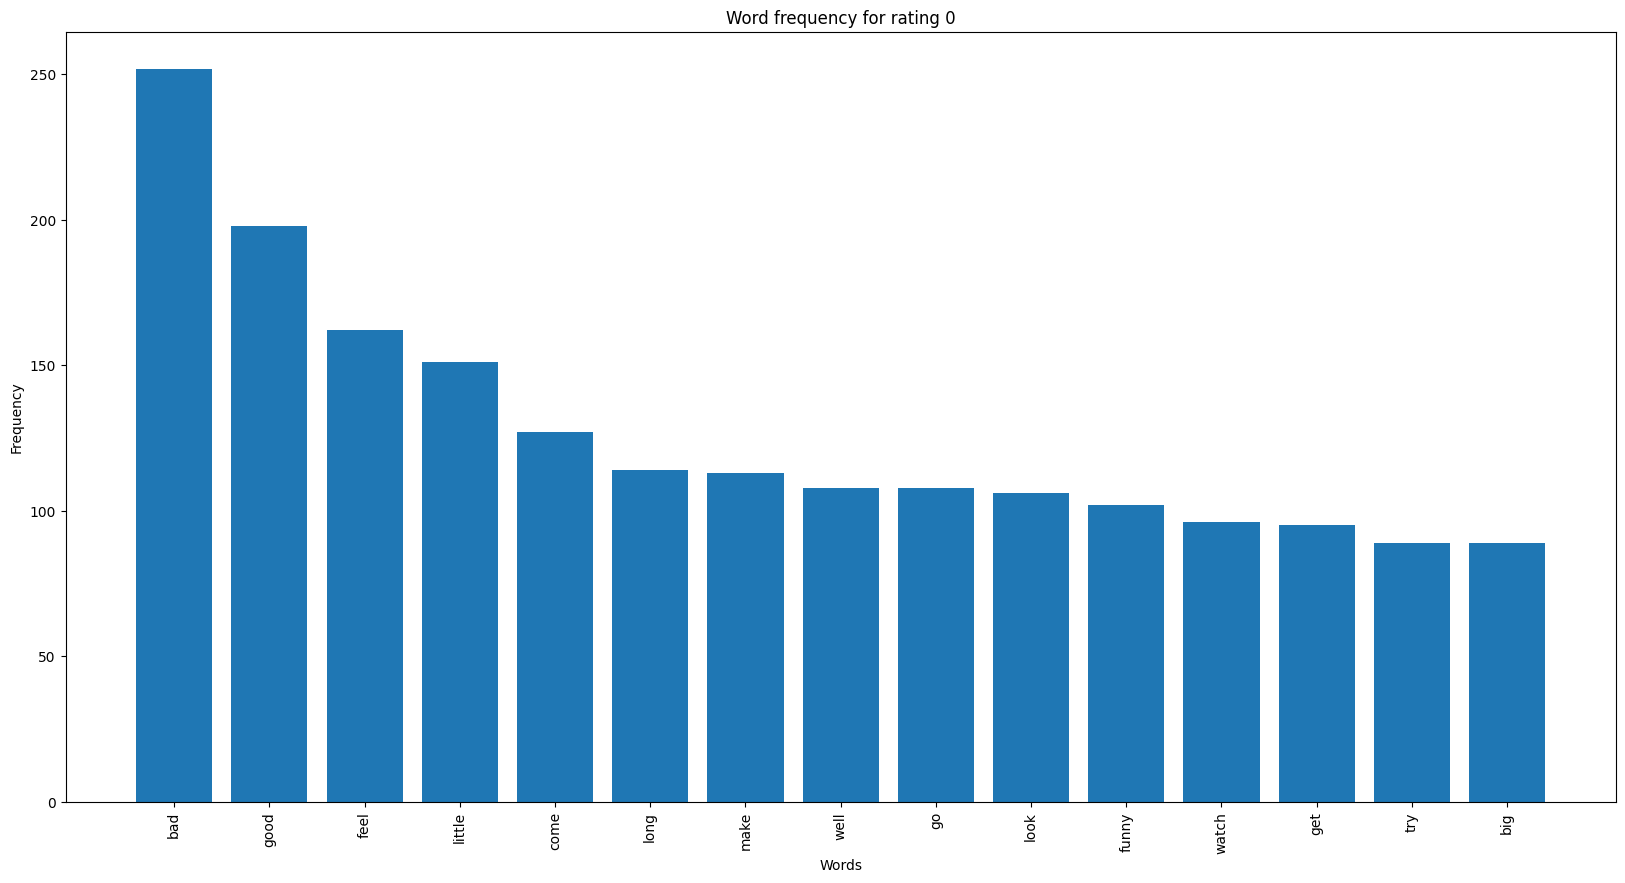

In [17]:
for i in df[label_col].unique():
    filtered_df = df[df[label_col] == i]
    all_words = [
        word for tokens in filtered_df["cleaned_text_tokens"] for word in tokens
    ]
    word_counts = Counter(all_words)
    word_freq_df = pd.DataFrame(
        word_counts.items(), columns=["word", "count"]
    ).sort_values(by="count", ascending=False)
    plt.figure(figsize=(20, 10))
    plt.bar(word_freq_df["word"][0:15], word_freq_df["count"][0:15])
    plt.xticks(rotation=90)
    plt.title(f"Word frequency for rating {i}")
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.show()

### Dodatkowe pytania

**- jaka jest charakterystyka tekstu (np. długość, czystość)? (opisane w dodatkowych pytaniach)**

In [18]:
text_data = []

for i in df[label_col].unique():
    filtered_df = df[df[label_col] == i]

    text_data.append(
        {
            "avg length": filtered_df["review_length"].mean(),
            "avg sentence count": filtered_df["review_text"]
            .str.split(r"[.!?]")
            .str.len()
            .mean(),
            "avg unique word count": filtered_df["unique_word_count"].mean(),
            "avg exclamation count": filtered_df["exclamation_count"].mean(),
        }
    )

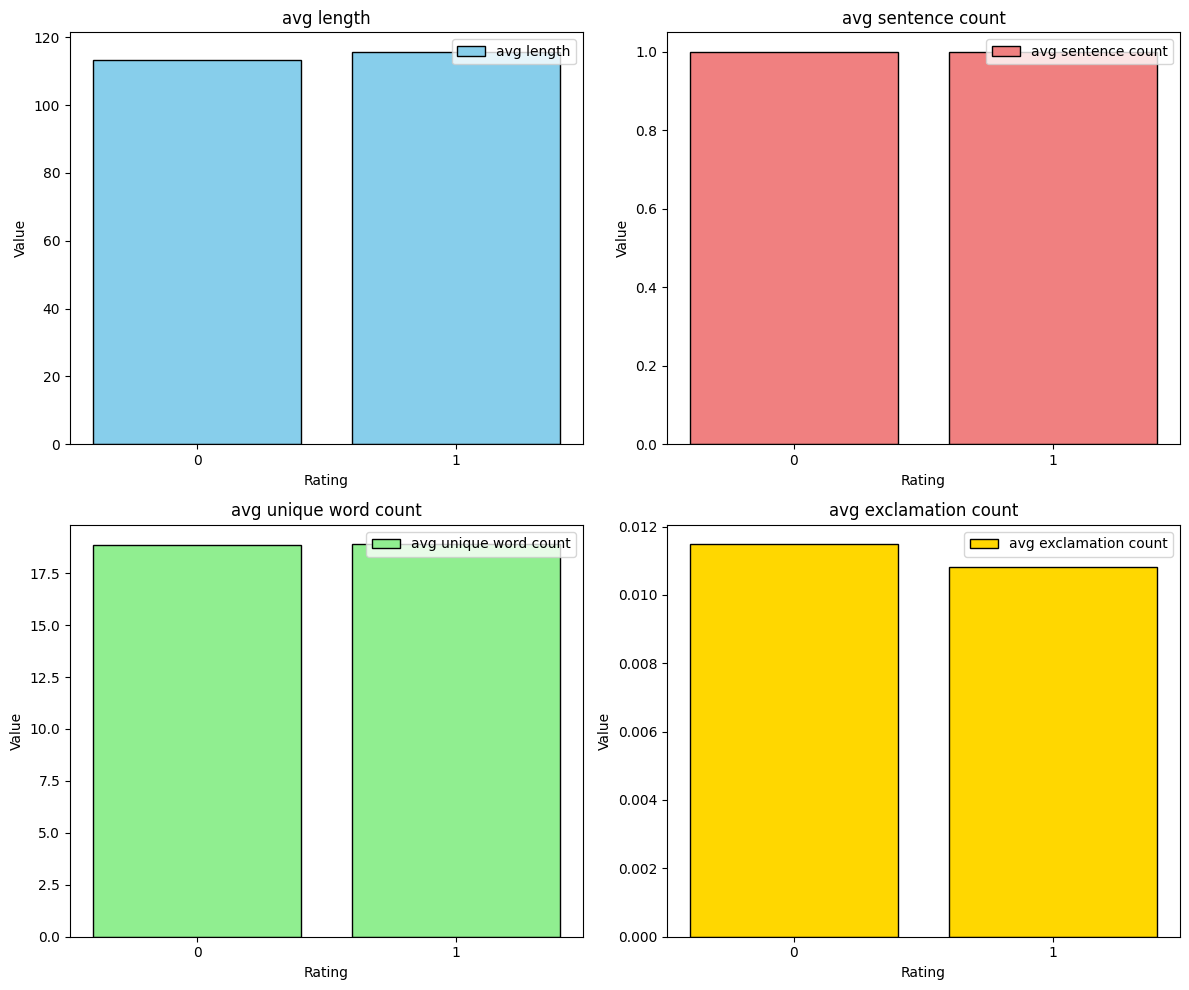

In [19]:
categories = [
    "avg length",
    "avg sentence count",
    "avg unique word count",
    "avg exclamation count",
]
ratings = df[label_col].unique()
colors = ["skyblue", "lightcoral", "lightgreen", "gold"]

values = {category: [entry[category] for entry in text_data] for category in categories}

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for ax, category, color in zip(axes.flatten(), categories, colors):
    bars = ax.bar(
        ratings, values[category], color=color, edgecolor="black", label=category
    )

    ax.set_title(category)
    ax.set_xlabel("Rating")
    ax.set_ylabel("Value")
    ax.set_xticks(ratings)
    ax.legend()

plt.tight_layout()
plt.show()

**Czy rozkład klas w zmiennej wyjściowej (LABEL-rating) jest zrównoważony?**

<Axes: xlabel='label'>

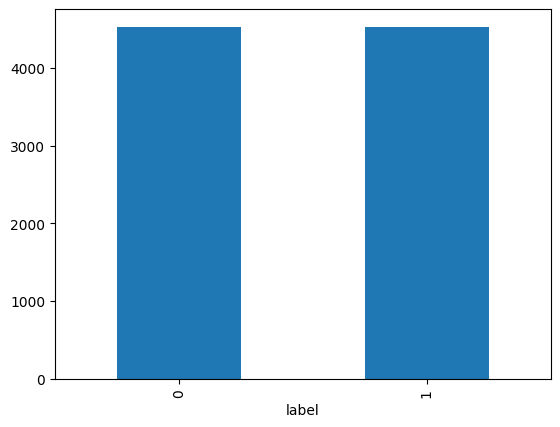

In [20]:
df[label_col].value_counts().sort_index().plot(kind="bar")

**Czy są duplikaty w zbiorze danych?**

In [21]:
# df.duplicated().sum()